## With Difusers

In [ ]:
!pip install -q -U transformers==4.26.1
!pip install -q -U diffusers==0.14.0
!pip install -q -U onnx==1.13.1
# !pip install -q -U onnxruntime==1.14.1
!pip install -q -U onnxruntime-gpu==1.14.1
!pip install -q -U basicsr==1.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 13.0 MB/s eta 0:00:00
 

In [ ]:
# !invisible_watermark==0.1.5
# !basicsr==1.4.2
# !einops==0.6.0
# !omegaconf==2.3.0
# !pytorch_lightning==1.5.9
# !kornia==0.6.8
# !pudb
# !imageio
# !imageio-ffmpeg
# !k-diffusion
# !webdataset
# !open-clip-torch
# !safetensors
# !timm

In [ ]:
%cd /content
# !git clone https://github.com/cloneofsimo/t2i-adapter-diffusers.git
!git clone https://github.com/ffletcherr/t2i-adapter-diffusers.git

/content
Cloning into 't2i-adapter-diffusers'...
remote: Enumerating objects: 168, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 168 (delta 71), reused 133 (delta 47), pack-reused 0
Receiving objects: 100% (168/168), 10.96 MiB | 8.69 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
import inspect
from typing import Union, Optional, List, Callable, Dict, Any

import torch
from diffusers.pipelines.onnx_utils import ORT_TO_NP_TYPE
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput

def torch_run_sd(
    self,
    adapter_features,
    prompt: Union[str, List[str]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
    negative_prompt: Optional[Union[str, List[str]]] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
    latents: Optional[torch.FloatTensor] = None,
    prompt_embeds: Optional[torch.FloatTensor] = None,
    negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    output_type: Optional[str] = "pil",
    return_dict: bool = True,
    callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
    callback_steps: int = 1,
    cross_attention_kwargs: Optional[Dict[str, Any]] = None,
):
    # 0. Default height and width to unet
    height = height or self.unet.config.sample_size * self.vae_scale_factor
    width = width or self.unet.config.sample_size * self.vae_scale_factor

    # 1. Check inputs. Raise error if not correct
    self.check_inputs(
        prompt, height, width, callback_steps, negative_prompt, prompt_embeds, negative_prompt_embeds
    )

    # 2. Define call parameters
    if prompt is not None and isinstance(prompt, str):
        batch_size = 1
    elif prompt is not None and isinstance(prompt, list):
        batch_size = len(prompt)
    else:
        batch_size = prompt_embeds.shape[0]

    device = self._execution_device
    # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
    # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
    # corresponds to doing no classifier free guidance.
    do_classifier_free_guidance = guidance_scale > 1.0

    # 3. Encode input prompt
    prompt_embeds = self._encode_prompt(
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
        prompt_embeds=prompt_embeds,
        negative_prompt_embeds=negative_prompt_embeds,
    )

    # 4. Prepare timesteps
    self.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps = self.scheduler.timesteps

    # 5. Prepare latent variables
    num_channels_latents = self.unet.in_channels
    latents = self.prepare_latents(
        batch_size * num_images_per_prompt,
        num_channels_latents,
        height,
        width,
        prompt_embeds.dtype,
        device,
        generator,
        latents,
    )

    # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
    extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

    # 7. Denoising loop
    num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
    with self.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=cross_attention_kwargs,
                f_1=adapter_features[0],
                f_2=adapter_features[1],
                f_3=adapter_features[2],
                f_4=adapter_features[3],
            ).sample

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).prev_sample

            # call the callback, if provided
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                progress_bar.update()
                if callback is not None and i % callback_steps == 0:
                    callback(i, t, latents)

    if output_type == "latent":
        image = latents
        has_nsfw_concept = None
    elif output_type == "pil":
        # 8. Post-processing
        image = self.decode_latents(latents)

        # 9. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

        # 10. Convert to PIL
        image = self.numpy_to_pil(image)
    else:
        # 8. Post-processing
        image = self.decode_latents(latents)

        # 9. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)

    # Offload last model to CPU
    if hasattr(self, "final_offload_hook") and self.final_offload_hook is not None:
        self.final_offload_hook.offload()

    if not return_dict:
        return (image, has_nsfw_concept)

    return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
%cd /content/t2i-adapter-diffusers

import torch

from diffusers import StableDiffusionPipeline
from t2i_adapters import patch_pipe

StableDiffusionPipeline.run_by_adapter = torch_run_sd

# 1. Define model and patch to t2i-adapter
model_id = "CompVis/stable-diffusion-v1-4"  # "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
patch_pipe(pipe)

/content/t2i-adapter-diffusers


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
The config attributes {'projection_class_embeddings_input_dim': None} were passed to T2IAdapterUNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
%cd /content/t2i-adapter-diffusers
from t2i_adapters import patch_pipe, Adapter, T2IAdapterUNet2DConditionModel

import cv2
from basicsr.utils import img2tensor

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

device = "cuda"
# 2 Extract features with adapter
adapter = Adapter.from_pretrained("canny").to(device)

/content/t2i-adapter-diffusers


Downloading: "https://huggingface.co/TencentARC/T2I-Adapter/resolve/main/models/t2iadapter_canny_sd14v1.pth" to /root/.cache/torch/hub/checkpoints/t2iadapter_canny_sd14v1.pth


  0%|          | 0.00/294M [00:00<?, ?B/s]

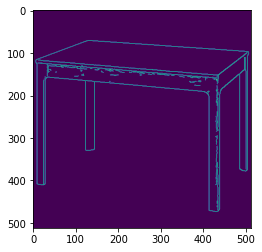

In [ ]:
# 2.1 prepare condition image
canny = cv2.imread("/content/table.png")
canny = cv2.resize(canny, (512, 512))
canny = cv2.Canny(canny, 50, 100)[..., None]
plt.imshow(canny)
plt.show()
canny = img2tensor(canny).unsqueeze(0) / 255.
canny = canny.to(device)

# 2.2 prepare feature
with torch.no_grad():
    adapter_features = adapter(canny)

DEFAULT_NEGATIVE_PROMPT = ["longbody", "lowres", "bad anatomy", "bad hands", "missing fingers", "extra digit", "fewer digits", "cropped", "worst quality", "low quality"]
DEFAULT_NEGATIVE_PROMPT = ", ".join(DEFAULT_NEGATIVE_PROMPT)

  0%|          | 0/50 [00:00<?, ?it/s]

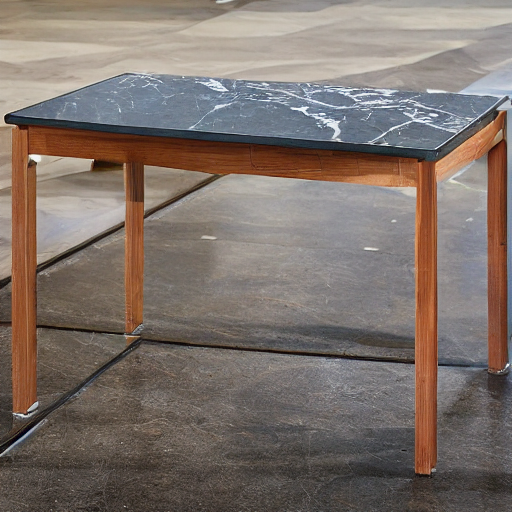

In [ ]:
with torch.no_grad():
    out = pipe.run_by_adapter(adapter_features=adapter_features, prompt="a table with wooden legs and marble surface", negative_prompt=DEFAULT_NEGATIVE_PROMPT)
out.images[0]

## Convert to ONNX

In [ ]:
# Copyright 2023 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import os
import shutil
from pathlib import Path

import onnx
import torch
from packaging import version
from torch.onnx import export

from diffusers import OnnxRuntimeModel, OnnxStableDiffusionPipeline, StableDiffusionPipeline


is_torch_less_than_1_11 = version.parse(version.parse(torch.__version__).base_version) < version.parse("1.11")


def onnx_export(
    model,
    model_args: tuple,
    output_path: Path,
    ordered_input_names,
    output_names,
    dynamic_axes,
    opset,
    use_external_data_format=False,
):
    output_path.parent.mkdir(parents=True, exist_ok=True)
    # PyTorch deprecated the `enable_onnx_checker` and `use_external_data_format` arguments in v1.11,
    # so we check the torch version for backwards compatibility
    if is_torch_less_than_1_11:
        export(
            model,
            model_args,
            f=output_path.as_posix(),
            input_names=ordered_input_names,
            output_names=output_names,
            dynamic_axes=dynamic_axes,
            do_constant_folding=True,
            use_external_data_format=use_external_data_format,
            enable_onnx_checker=True,
            opset_version=opset,
        )
    else:
        export(
            model,
            model_args,
            f=output_path.as_posix(),
            input_names=ordered_input_names,
            output_names=output_names,
            dynamic_axes=dynamic_axes,
            do_constant_folding=True,
            opset_version=opset,
        )


In [ ]:
fp16 = True
pipeline = pipe
output_path = "/content/onnx-t2i-sd-v1-4"
opset = 14

with torch.no_grad():
    dtype = torch.float16 if fp16 else torch.float32
    if fp16 and torch.cuda.is_available():
        device = "cuda"
    elif fp16 and not torch.cuda.is_available():
        raise ValueError("`float16` model export is only supported on GPUs with CUDA")
    else:
        device = "cpu"
    output_path = Path(output_path)

    # # TEXT ENCODER
    num_tokens = pipeline.text_encoder.config.max_position_embeddings
    text_hidden_size = pipeline.text_encoder.config.hidden_size
    # pipe.tokenizer.model_max_length is 77
    # text_input.input_ids.shape is [batch_size, 77] at max
    text_input = pipeline.tokenizer(
        "A sample prompt",
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    onnx_export(
        pipeline.text_encoder,
        # casting to torch.int32 until the CLIP fix is released: https://github.com/huggingface/transformers/pull/18515/files
        model_args=(text_input.input_ids.to(device=device, dtype=torch.int32)),
        output_path=output_path / "text_encoder" / "model.onnx",
        ordered_input_names=["input_ids"],
        output_names=["last_hidden_state", "pooler_output"],
        dynamic_axes={
            "input_ids": {0: "batch", 1: "sequence"},
        },
        opset=opset,
    )
    del pipeline.text_encoder

    # UNET
    unet_in_channels = pipeline.unet.config.in_channels
    unet_sample_size = pipeline.unet.config.sample_size
    unet_path = output_path / "unet" / "model.onnx"
    onnx_export(
        pipeline.unet,
        model_args=(
            torch.randn(2, unet_in_channels, unet_sample_size, unet_sample_size).to(device=device, dtype=dtype),
            torch.randn(2).to(device=device, dtype=dtype),
            torch.randn(2, num_tokens, text_hidden_size).to(device=device, dtype=dtype),
            torch.randn([2, 320, 64, 64]).to(device=device, dtype=dtype),
            torch.randn([2, 640, 32, 32]).to(device=device, dtype=dtype), 
            torch.randn([2, 1280, 16, 16]).to(device=device, dtype=dtype), 
            torch.randn([2, 1280, 8, 8]).to(device=device, dtype=dtype), 
            False,
        ),
        output_path=unet_path,
        # f_4 and return_dict is not apear in onnx model's inputs.
        ordered_input_names=[
            "sample", "timestep", "encoder_hidden_states", "f_1", "f_2", "f_3", "f_4", "return_dict"
            ],
        output_names=["out_sample"],  # has to be different from "sample" for correct tracing
        dynamic_axes={
            "sample": {0: "batch", 1: "channels", 2: "height", 3: "width"},
            "timestep": {0: "batch"},
            "encoder_hidden_states": {0: "batch", 1: "sequence"},
            "f_1": {0: "batch"},
            "f_2": {0: "batch"},
            "f_3": {0: "batch"},
            "f_4": {0: "batch"},
        },
        opset=opset,
        use_external_data_format=True,  # UNet is > 2GB, so the weights need to be split
    )
    unet_model_path = str(unet_path.absolute().as_posix())
    unet_dir = os.path.dirname(unet_model_path)
    unet = onnx.load(unet_model_path)
    # clean up existing tensor files
    shutil.rmtree(unet_dir)
    os.mkdir(unet_dir)
    # collate external tensor files into one
    onnx.save_model(
        unet,
        unet_model_path,
        save_as_external_data=True,
        all_tensors_to_one_file=True,
        location="weights.pb",
        convert_attribute=False,
    )
    del pipeline.unet

    # VAE ENCODER
    vae_encoder = pipeline.vae
    vae_in_channels = vae_encoder.config.in_channels
    vae_sample_size = vae_encoder.config.sample_size
    # need to get the raw tensor output (sample) from the encoder
    vae_encoder.forward = lambda sample, return_dict: vae_encoder.encode(sample, return_dict)[0].sample()
    onnx_export(
        vae_encoder,
        model_args=(
            torch.randn(1, vae_in_channels, vae_sample_size, vae_sample_size).to(device=device, dtype=dtype),
            False,
        ),
        output_path=output_path / "vae_encoder" / "model.onnx",
        ordered_input_names=["sample", "return_dict"],
        output_names=["latent_sample"],
        dynamic_axes={
            "sample": {0: "batch", 1: "channels", 2: "height", 3: "width"},
        },
        opset=opset,
    )

    # VAE DECODER
    vae_decoder = pipeline.vae
    vae_latent_channels = vae_decoder.config.latent_channels
    vae_out_channels = vae_decoder.config.out_channels
    # forward only through the decoder part
    vae_decoder.forward = vae_encoder.decode
    onnx_export(
        vae_decoder,
        model_args=(
            torch.randn(1, vae_latent_channels, unet_sample_size, unet_sample_size).to(device=device, dtype=dtype),
            False,
        ),
        output_path=output_path / "vae_decoder" / "model.onnx",
        ordered_input_names=["latent_sample", "return_dict"],
        output_names=["sample"],
        dynamic_axes={
            "latent_sample": {0: "batch", 1: "channels", 2: "height", 3: "width"},
        },
        opset=opset,
    )
    del pipeline.vae

    # SAFETY CHECKER
    if pipeline.safety_checker is not None:
        safety_checker = pipeline.safety_checker
        clip_num_channels = safety_checker.config.vision_config.num_channels
        clip_image_size = safety_checker.config.vision_config.image_size
        safety_checker.forward = safety_checker.forward_onnx
        onnx_export(
            pipeline.safety_checker,
            model_args=(
                torch.randn(
                    1,
                    clip_num_channels,
                    clip_image_size,
                    clip_image_size,
                ).to(device=device, dtype=dtype),
                torch.randn(1, vae_sample_size, vae_sample_size, vae_out_channels).to(device=device, dtype=dtype),
            ),
            output_path=output_path / "safety_checker" / "model.onnx",
            ordered_input_names=["clip_input", "images"],
            output_names=["out_images", "has_nsfw_concepts"],
            dynamic_axes={
                "clip_input": {0: "batch", 1: "channels", 2: "height", 3: "width"},
                "images": {0: "batch", 1: "height", 2: "width", 3: "channels"},
            },
            opset=opset,
        )
        del pipeline.safety_checker
        safety_checker = OnnxRuntimeModel.from_pretrained(output_path / "safety_checker")
        feature_extractor = pipeline.feature_extractor
    else:
        safety_checker = None
        feature_extractor = None

    onnx_pipeline = OnnxStableDiffusionPipeline(
        vae_encoder=OnnxRuntimeModel.from_pretrained(output_path / "vae_encoder"),
        vae_decoder=OnnxRuntimeModel.from_pretrained(output_path / "vae_decoder"),
        text_encoder=OnnxRuntimeModel.from_pretrained(output_path / "text_encoder"),
        tokenizer=pipeline.tokenizer,
        unet=OnnxRuntimeModel.from_pretrained(output_path / "unet"),
        scheduler=pipeline.scheduler,
        safety_checker=safety_checker,
        feature_extractor=feature_extractor,
        requires_safety_checker=safety_checker is not None,
    )

    onnx_pipeline.save_pretrained(output_path)
    print("ONNX pipeline saved to", output_path)

    del pipeline
    del onnx_pipeline
    _ = OnnxStableDiffusionPipeline.from_pretrained(output_path, provider="CPUExecutionProvider")
    print("ONNX pipeline is loadable")

## Inference ONNX

if you have GPU-RAM < 15GB restart runtime here.

In [ ]:
import inspect
import numpy as np
from diffusers.pipelines.onnx_utils import ORT_TO_NP_TYPE
from diffusers.pipelines.stable_diffusion import StableDiffusionPipelineOutput
from typing import Union, Optional, List, Callable, Dict, Any

def onnx_run_sd(
        self,
        adapter_features,
        prompt: Union[str, List[str]],
        height: Optional[int] = 512,
        width: Optional[int] = 512,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[np.random.RandomState] = None,
        latents: Optional[np.ndarray] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, np.ndarray], None]] = None,
        callback_steps: int = 1,
    ):
        if isinstance(prompt, str):
            batch_size = 1
        elif isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompt)}")

        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        if (callback_steps is None) or (
            callback_steps is not None and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

        if generator is None:
            generator = np.random

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        prompt_embeds = self._encode_prompt(
            prompt, num_images_per_prompt, do_classifier_free_guidance, negative_prompt
        )

        # get the initial random noise unless the user supplied it
        latents_dtype = prompt_embeds.dtype
        latents_shape = (batch_size * num_images_per_prompt, 4, height // 8, width // 8)
        if latents is None:
            latents = generator.randn(*latents_shape).astype(latents_dtype)
        elif latents.shape != latents_shape:
            raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")

        # set timesteps
        self.scheduler.set_timesteps(num_inference_steps)

        latents = latents * np.float64(self.scheduler.init_noise_sigma)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        timestep_dtype = next(
            (input.type for input in self.unet.model.get_inputs() if input.name == "timestep"), "tensor(float)"
        )
        timestep_dtype = ORT_TO_NP_TYPE[timestep_dtype]

        for i, t in enumerate(self.progress_bar(self.scheduler.timesteps)):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(torch.from_numpy(latent_model_input), t)
            latent_model_input = latent_model_input.cpu().numpy()

            # predict the noise residual
            timestep = np.array([t], dtype=timestep_dtype)
            noise_pred = self.unet(
                sample=latent_model_input,
                timestep=timestep,
                encoder_hidden_states=prompt_embeds,
                f_1=adapter_features[0],
                f_2=adapter_features[1],
                f_3=adapter_features[2],
                # f_4=adapter_features[3],
            )
            noise_pred = noise_pred[0]

            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = np.split(noise_pred, 2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            scheduler_output = self.scheduler.step(
                torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs
            )
            latents = scheduler_output.prev_sample.numpy()

            # call the callback, if provided
            if callback is not None and i % callback_steps == 0:
                callback(i, t, latents)

        latents = 1 / 0.18215 * latents
        # image = self.vae_decoder(latent_sample=latents)[0]
        # it seems likes there is a strange result for using half-precision vae decoder if batchsize>1
        image = np.concatenate(
            [self.vae_decoder(latent_sample=latents[i : i + 1])[0] for i in range(latents.shape[0])]
        )

        image = np.clip(image / 2 + 0.5, 0, 1)
        image = image.transpose((0, 2, 3, 1))

        if self.safety_checker is not None:
            safety_checker_input = self.feature_extractor(
                self.numpy_to_pil(image), return_tensors="np"
            ).pixel_values.astype(image.dtype)

            images, has_nsfw_concept = [], []
            for i in range(image.shape[0]):
                image_i, has_nsfw_concept_i = self.safety_checker(
                    clip_input=safety_checker_input[i : i + 1], images=image[i : i + 1]
                )
                images.append(image_i)
                has_nsfw_concept.append(has_nsfw_concept_i[0])
            image = np.concatenate(images)
        else:
            has_nsfw_concept = None

        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

In [ ]:
%cd /content/t2i-adapter-diffusers
from diffusers import OnnxStableDiffusionPipeline
from t2i_adapters import patch_pipe, Adapter, T2IAdapterUNet2DConditionModel

import cv2
from basicsr.utils import img2tensor

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

OnnxStableDiffusionPipeline.run_by_adapter = onnx_run_sd

# 1. Define model and patch to t2i-adapter
output_path = "/content/onnx-t2i-sd-v1-4"
pipe = OnnxStableDiffusionPipeline.from_pretrained(
    output_path, provider="CUDAExecutionProvider", revision="onnx"
    )

device = "cuda"
# 2 Extract features with adapter
adapter = Adapter.from_pretrained("canny").to(device)

/content/t2i-adapter-diffusers


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


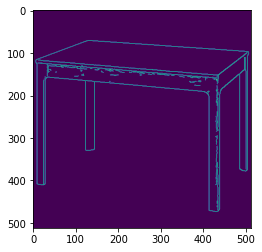

In [ ]:
# 2.1 prepare condition image
canny = cv2.imread("/content/table.png")
canny = cv2.resize(canny, (512, 512))
canny = cv2.Canny(canny, 50, 100)[..., None]
plt.imshow(canny)
plt.show()
canny = img2tensor(canny).unsqueeze(0) / 255.
canny = canny.to(device)

# 2.2 prepare feature
with torch.no_grad():
    adapter_features = adapter(canny)

DEFAULT_NEGATIVE_PROMPT = ["longbody", "lowres", "bad anatomy", "bad hands", "missing fingers", "extra digit", "fewer digits", "cropped", "worst quality", "low quality"]
DEFAULT_NEGATIVE_PROMPT = ", ".join(DEFAULT_NEGATIVE_PROMPT)

  0%|          | 0/51 [00:00<?, ?it/s]

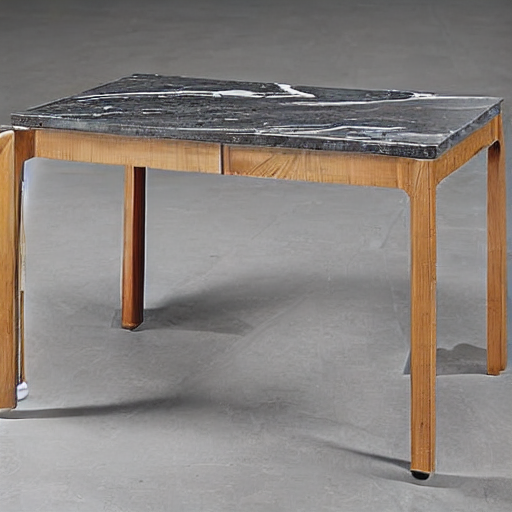

In [ ]:
# sample...
out = pipe.run_by_adapter(
    adapter_features=[f.cpu().type(torch.float16) for f in adapter_features],
    prompt="a table with wooden legs and marble surface",
    negative_prompt=DEFAULT_NEGATIVE_PROMPT)
out.images[0]

In [ ]:
for inp in pipe.unet.model.get_inputs():
    print(inp.name)
    print(inp.shape)

sample
['batch', 'channels', 'height', 'width']
timestep
['batch']
encoder_hidden_states
['batch', 'sequence', 768]
f_1
['batch', 320, 64, 64]
f_2
['batch', 640, 32, 32]
f_3
['batch', 1280, 16, 16]


## Convert to TRT

if you have GPU-RAM < 15GB restart runtime here.

In [ ]:
!pip install tensorrt==8.6.0
!python -m pip install colored==1.4.4 polygraphy==0.44.2 --extra-index-url https://pypi.ngc.nvidia.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.ngc.nvidia.com
  Using cached colored-1.4.4.tar.gz (36 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 KB 14.4 MB/s eta 0:00:00
  Created wheel for colored: filename=colored-1.4.4-py3-none-any.whl size=14268 sha256=c878382617f50b2bde92b515363aece6ee514ad2a372cee1dbf4243035dd81ee
  Stored in directory: /root/.cache/pip/wheels/7a/f5/27/54cfa98930f018369067d8d02e508e053b1fec3704c258916b
Successfully built colored


In [ ]:
!mkdir /content/trt-t2i-sd-v1-4
!mkdir /content/trt-t2i-sd-v1-4/unet
!mkdir /content/trt-t2i-sd-v1-4/text_encoder
!mkdir /content/trt-t2i-sd-v1-4/vae_encoder
!mkdir /content/trt-t2i-sd-v1-4/vae_decoder
!mkdir /content/trt-t2i-sd-v1-4/safety_checker

mkdir: cannot create directory ‘/content/trt-t2i-sd-v1-4’: File exists
mkdir: cannot create directory ‘/content/trt-t2i-sd-v1-4/unet’: File exists


In [1]:
!polygraphy convert /content/onnx-t2i-sd-v1-4/vae_decoder/model.onnx -o /content/trt-t2i-sd-v1-4/vae_decoder/model.engine \
    --trt-min-shapes latent_sample:[1,4,64,64] \
    --trt-opt-shapes latent_sample:[1,4,64,64] \
    --trt-max-shapes latent_sample:[1,4,64,64] \
    --fp16

[W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[I]     Configuring with profiles: [Profile().add('latent_sample', min=[1, 4, 64, 64], opt=[1, 4, 64, 64], max=[1, 4, 64, 64])]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 15101.81 MiB, TACTIC_DRAM: 15101.81 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTI

In [ ]:
!polygraphy convert /content/onnx-t2i-sd-v1-4/vae_encoder/model.onnx -o /content/trt-t2i-sd-v1-4/vae_encoder/model.engine \
    --trt-min-shapes sample:[1,3,512,512] \
    --trt-opt-shapes sample:[1,3,512,512] \
    --trt-max-shapes sample:[4,3,512,512] \
    --fp16

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[I]     Configuring with profiles: [Profile().add('sample', min=[1, 3, 512, 512], opt=[1, 3, 512, 512], max=[4, 3, 512, 512])]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 15101.81 MiB, TACTIC_DRAM: 15101.81 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[W] If this is not the desired behavior, please

In [ ]:
!polygraphy convert /content/onnx-t2i-sd-v1-4/text_encoder/model.onnx -o /content/trt-t2i-sd-v1-4/text_encoder/model.engine \
    --trt-min-shapes input_ids:[1,7] --trt-opt-shapes input_ids:[1,16] --trt-max-shapes input_ids:[4,77] \
    --fp16

[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[W] onnx2trt_utils.cpp:70: TensorRT is using FLOAT32 precision to run an INT32 ArgMax / ArgMin. Rounding errors may occur for large integer values
[W] Tensor DataType is determined at build time for tensors not marked as input or output.
[I]     Configuring with profiles: [Profile().add('input_ids', min=[1, 7], opt=[1, 16], max=[4, 77])]
[I] Building engine with configuration:
    Flags                  | [FP16]
    Engine Capability      | EngineCapability.DEFAULT
    Memory Pools           | [WORKSPACE: 15101.81 MiB, TACTIC_DRAM: 15101.81 MiB]
    Tactic Sources         | [CUBLAS, CUBLAS_LT, CUDNN, EDGE_MASK_CONVOLUTIONS, JIT_CONVOLUTIONS]
    Profiling Verbosity    | ProfilingVerbosity.DETAILED
    Preview Features       | [FASTER_DYNAMIC_SHAPES_0805, DISABLE_EXTERNAL_TACTIC_SOURCES_FOR_CORE_0805]
[W] Detected layernorm 

In [ ]:
!polygraphy convert /content/onnx-t2i-sd-v1-4/safety_checker/model.onnx -o /content/trt-t2i-sd-v1-4/safety_checker/model.engine \
    --trt-min-shapes clip_input:[1,3,224,224] images:[1,512,512,3] \
    --trt-opt-shapes clip_input:[1,3,224,224] images:[1,512,512,3] \
    --trt-max-shapes clip_input:[4,3,224,224] images:[4,512,512,3] \
    --fp16

[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:81] The total number of bytes read was 608683383
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:604] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:81] The total number of bytes read was 608683383
[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while Tenso

In [ ]:
!polygraphy convert /content/onnx-t2i-sd-v1-4/unet/model.onnx -o /content/trt-t2i-sd-v1-4/unet/model.engine \
    --trt-min-shapes sample:[1,4,64,64] timestep:[1] encoder_hidden_states:[1,1,768] f_1:[1,320,64,64] f_2:[1,640,32,32] f_3:[1,1280,16,16] \
    --trt-opt-shapes sample:[1,4,64,64] timestep:[1] encoder_hidden_states:[1,64,768] f_1:[1,320,64,64] f_2:[1,640,32,32] f_3:[1,1280,16,16] \
    --trt-max-shapes sample:[4,4,64,64] timestep:[4] encoder_hidden_states:[4,64,768] f_1:[4,320,64,64] f_2:[4,640,32,32] f_3:[4,1280,16,16] \
    --fp16

mkdir: cannot create directory ‘/content/trt-t2i-sd-v1-4’: File exists
[ERROR] Exception caught in log(): KeyboardInterrupt: 
[W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
[I]     Configuring with profiles: [Profile().add('sample', min=[1, 4, 64, 64], opt=[1, 4, 64, 64], max=[4, 4, 64, 64]).add('timestep', min=[1], opt=[1], max=[4]).add('encoder_hidden_states', min=[1, 1, 768], opt=[1, 64, 768], max=[4, 64, 768]).add('f_1', min=[1, 320, 64, 64], opt=[1, 320, 64, 64], max=[4, 320, 64, 64]).add('f_2', min=[1, 640, 32, 32], opt=[1,